The following notebook, reviews the methodology by which we can build a recurrent neural network that is able to analyze text sentences and determine whether they are congruent in meaning or contradictory in terms of meaning.
The notebook uses the dataset found in this link: https://nlp.stanford.edu/projects/snli/
Available within the kaggle community (https://www.kaggle.com/datasets/stanfordu/stanford-natural-language-inference-corpus), the study focused on two cases: (the first is compatibility in terms of meaning, and the second case is complete difference in terms of meaning).
The adopted methodology relied on the use of TimeDistributed and working on the formulation of the input of the neural network in the form of two sentences, and in each sentence the operations are applied to it inclusively independent of the second sentence, and the aim of this is the ability to extract the characteristics and link the sequence of words for each sentence, and then determine whether the two sentences are identical in terms of meaning Im different.

In [ ]:
  #1
  !wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-12-14 00:38:33--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-14 00:38:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.11MB/s    in 4m 41s  

2022-12-14 00:43:16 (2.93 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
#2
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
#3
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#4
import opendatasets as op
op.download("https://www.kaggle.com/datasets/stanfordu/stanford-natural-language-inference-corpus")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: varshahrishikesh
Your Kaggle Key: ··········


100%|██████████| 44.4M/44.4M [00:03<00:00, 14.5MB/s]


In [ ]:
#5
datasetFolder = "stanford-natural-language-inference-corpus"

In [ ]:
#6
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from tensorflow.keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

In [ ]:
#7
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#8
train_dataset = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_train.csv"))
test_dataset = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_test.csv"))
validation_dataset = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_dev.csv"))


In [ ]:
#9
full_dataset = [train_dataset, test_dataset, validation_dataset]
dataset = pd.concat(full_dataset)
#pd.concat is a function in the pandas library that can be used to concatenate pandas objects along a given axis.
#This function is often used to combine multiple DataFrames that have the same structure 
#but different data, or to combine the results of different operations on a single DataFrame.

In [ ]:
#10
dataset.head()
#dataset.head is a method in the pandas library that returns the first few rows of a DataFrame. By default, it returns the first five rows, but you can specify the number of rows you want to return by passing an integer value to the head method. This method is often used to quickly preview the data in a DataFrame to get a sense of what it looks like and to check for any errors or inconsistencies. 

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [ ]:
#11
dataset = dataset[['gold_label', 'sentence1', 'sentence2']]

In [ ]:
#12
len(dataset)

570152

In [ ]:
#13
dataset.isnull().sum()

gold_label    0
sentence1     0
sentence2     6
dtype: int64

In [ ]:
#14
dataset.describe()

,gold_label,sentence1,sentence2
count,570152,570152,570146
unique,4,157351,496642
top,entailment,A dog in a field.,A man is sleeping.
freq,190113,33,343


In [ ]:
#15
dataset.dropna(axis=0, inplace=True)

In [ ]:
#16
len(dataset)

570146

In [ ]:
#17
dataset = dataset.loc[dataset['gold_label'] != "-"]
dataset = dataset.loc[dataset['gold_label'] != "neutral"]

In [ ]:
#18
len(dataset)

379811

In [ ]:
#19
dataset = dataset.sample(frac = 1)

In [ ]:
#20
dataset.head()

,gold_label,sentence1,sentence2
358888,contradiction,A woman wearing headphones walks down the street.,A woman wearing earmuffs is sitting on the couch.
419571,contradiction,"an old man, with a gray beard, riding his bike",An old man is driving a car.
338870,contradiction,A kite surfer with a white vest gets airborne.,The golfer jumps in the air.
4778,entailment,A man in a straw hat and another man in a stri...,The men have beverages.
445809,contradiction,"Two girls doing cartwheels, while other childr...",girls are watching tv


In [ ]:
#21
sentence1 = dataset['sentence1']
sentence2 = dataset['sentence2']
label = dataset['gold_label']

In [ ]:
#22
label.unique()

array(['contradiction', 'entailment'], dtype=object)

In [ ]:
#23
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

In [ ]:
#24
sentence1 = CleanFeatures(sentence1)
sentence2 = CleanFeatures(sentence2)

In [ ]:
#25
sentence1.head()

358888                woman wearing headphones walks street
419571                       old man gray beard riding bike
338870                 kite surfer white vest gets airborne
4778      man straw hat another man striped shirt drinki...
445809                   two girls cartwheels children look
Name: sentence1, dtype: object

In [ ]:
#26
sentence2.head()

358888    woman wearing earmuffs sitting couch
419571                     old man driving car
338870                        golfer jumps air
4778                             men beverages
445809                       girls watching tv
Name: sentence2, dtype: object

In [ ]:
#27
sentence1.shape

(379811,)

In [ ]:
#28
label.unique()

array(['contradiction', 'entailment'], dtype=object)

In [ ]:
#29
len(label)

379811

In [ ]:
#30
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape

(2, 379811)

In [ ]:
#31
all_sentences = all_sentences.reshape(-1,1 )

In [ ]:
#32
all_sentences = all_sentences.reshape(all_sentences.shape[0])

In [ ]:
all_sentences.shape

(759622,)

In [ ]:
#33
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(all_sentences)

for first sentences:

In [ ]:
#34
sentence1_seq = tokenizer.texts_to_sequences(sentence1)
sentence1 = pad_sequences(sentence1_seq)

In [ ]:
sentence1.shape

(379811, 43)

In [ ]:
sentence2_seq = tokenizer.texts_to_sequences(sentence2)
sentence2 = pad_sequences(sentence2_seq, maxlen= sentence1.shape[1])

In [ ]:
sentence2.shape

(379811, 43)

In [ ]:
sentence1

array([[   0,    0,    0, ...,  720,   99,   22],
       [   0,    0,    0, ...,  411,   36,   55],
       [   0,    0,    0, ...,  280,  513, 1562],
       ...,
       [   0,    0,    0, ...,   73,   48,  185],
       [   0,    0,    0, ..., 1498,  168,  523],
       [   0,    0,    0, ...,  289,   45, 1124]], dtype=int32)

In [ ]:
#35
label_ = LabelEncoder()
labels = label_.fit_transform(label)

In [ ]:
#36
labels

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#37
vocabulary = len(tokenizer.word_index)

In [ ]:
vocabulary

30607

In [ ]:
#38
labels = to_categorical(labels)

In [ ]:
#39
labels.shape

(379811, 2)

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
#39
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape

(2, 379811, 43)

In [ ]:
#40
all_sentences = all_sentences.reshape(all_sentences.shape[1], 2, all_sentences.shape[2])

In [ ]:
#40
all_sentences.shape

(379811, 2, 43)

In [ ]:
#41
def glove_word_embedding(file_name, vocabulary):
  embeddings_index = {}
  file_ = open(file_name)
  for line in file_:
      arr = line.split()
      single_word = arr[0]
      w = np.asarray(arr[1:],dtype='float32')
      embeddings_index[single_word] = w
  file_.close()
  max_words = vocabulary + 1
  word_index = tokenizer.word_index
  embedding_matrix = np.zeros((max_words,300)).astype(object)
  for word , i in word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector 
  return embedding_matrix            

In [ ]:
x = Input(shape=(all_sentences.shape[1], all_sentences.shape[2],))
p = TimeDistributed(Embedding(vocabulary + 1, 300))(x)
p = TimeDistributed(LSTM(128, return_sequences=True))(p)
p = TimeDistributed(LSTM(64, return_sequences=True))(p)
x1 = TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(p)
x2 = TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(p)
concat = tf.keras.layers.concatenate([x1, x2])
p = tf.keras.layers.Dropout(0.35)(concat)
p = Flatten()(p)
p = Dense(2, activation="softmax")(p)

In [ ]:
#42
m = tf.keras.models.Model(inputs = x, outputs = p)

In [ ]:
#43
m.layers[1].set_weights([glove_word_embedding("glove.6B.300d.txt", vocabulary)])
m.layers[1].trainable = False

In [ ]:
#44
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 43)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 2, 43, 300)  9182400     ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 2, 43, 128)  219648      ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

In [ ]:
#45
m.compile(loss="binary_crossentropy",optimizer='adam',metrics=[TruePositives(name='tp'),
                                                                     FalsePositives(name='fp'),
                                                                     TrueNegatives(name='tn'),
                                                                     FalseNegatives(name='fn'),
                                                                     "accuracy",
                                                                     Precision(name='precision'),
                                                                     Recall(name='recall'),
                                                                     AUC(name = "AUC")])

In [ ]:
#46
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 60, mode = 'min', restore_best_weights = True)

In [ ]:
$47
history_training = m.fit(all_sentences,labels,
                         epochs= 200,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                         callbacks=[ earlyStopping])

Epoch 1/200
371/371 [==============================] - 23s 63ms/step - loss: 0.5826 - tp: 251970.0000 - fp: 127841.0000 - tn: 251970.0000 - fn: 127841.0000 - accuracy: 0.6634 - precision: 0.6634 - recall: 0.6634 - AUC: 0.7439
Epoch 2/200
371/371 [==============================] - 23s 63ms/step - loss: 0.5757 - tp: 253647.0000 - fp: 126164.0000 - tn: 253647.0000 - fn: 126164.0000 - accuracy: 0.6678 - precision: 0.6678 - recall: 0.6678 - AUC: 0.7509
Epoch 3/200
371/371 [==============================] - 23s 62ms/step - loss: 0.5692 - tp: 255811.0000 - fp: 124000.0000 - tn: 255811.0000 - fn: 124000.0000 - accuracy: 0.6735 - precision: 0.6735 - recall: 0.6735 - AUC: 0.7578
Epoch 4/200
371/371 [==============================] - 23s 63ms/step - loss: 0.5633 - tp: 257137.0000 - fp: 122674.0000 - tn: 257137.0000 - fn: 122674.0000 - accuracy: 0.6770 - precision: 0.6770 - recall: 0.6770 - AUC: 0.7634
Epoch 5/200
371/371 [==============================] - 23s 63ms/step - loss: 0.5584 - tp: 258527

In [ ]:
#48
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

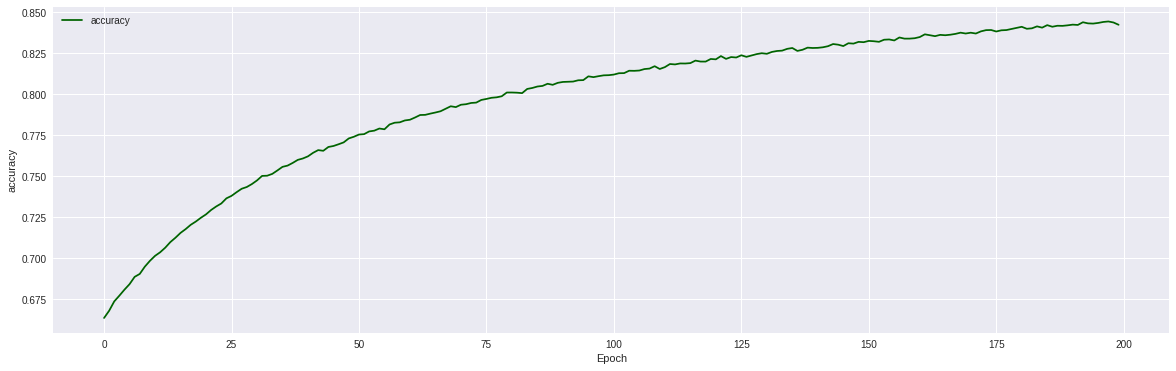

In [ ]:
#49
draw_plot(history_training.history['accuracy'],"darkgreen", "accuracy")

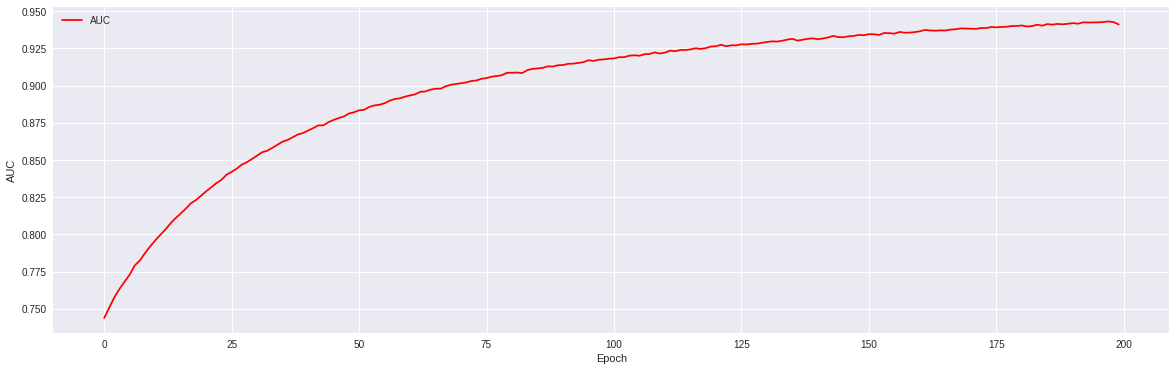

In [ ]:
#49
draw_plot(history_training.history['AUC'],"red", "AUC")

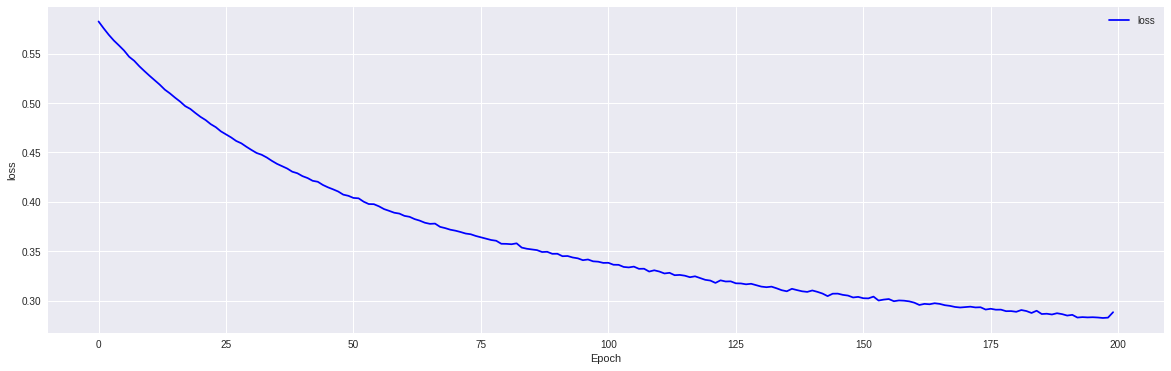

In [ ]:
#49
draw_plot(history_training.history['loss'],"blue", "loss")

In [ ]:
#50
m.evaluate(all_sentences,labels, batch_size = 1024,use_multiprocessing=True, workers = -1)

371/371 [==============================] - 10s 24ms/step - loss: 0.2478 - tp: 328741.0000 - fp: 51070.0000 - tn: 328741.0000 - fn: 51070.0000 - accuracy: 0.8655 - precision: 0.8655 - recall: 0.8655 - AUC: 0.9588


[0.24783550202846527,
 328741.0,
 51070.0,
 328741.0,
 51070.0,
 0.8655383586883545,
 0.8655383586883545,
 0.8655383586883545,
 0.9588214159011841]

In [ ]:
#51
y_pred = m.predict(all_sentences, batch_size=1024, verbose= 1)
y_pred = np.argmax(y_pred, axis = 1)

371/371 [==============================] - 8s 20ms/step


In [ ]:
y_pred

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
#52
y_test = np.argmax(labels, axis = 1)
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#53
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8655383861973456

In [ ]:
#54
res = tf.math.confusion_matrix(y_pred,y_test).numpy()

In [ ]:
#55
cm = pd.DataFrame(res,
                     index = ['contradiction', 'entailment'], 
                     columns = ['contradiction', 'entailment'])
cm

,contradiction,entailment
contradiction,170365,31735
entailment,19335,158376


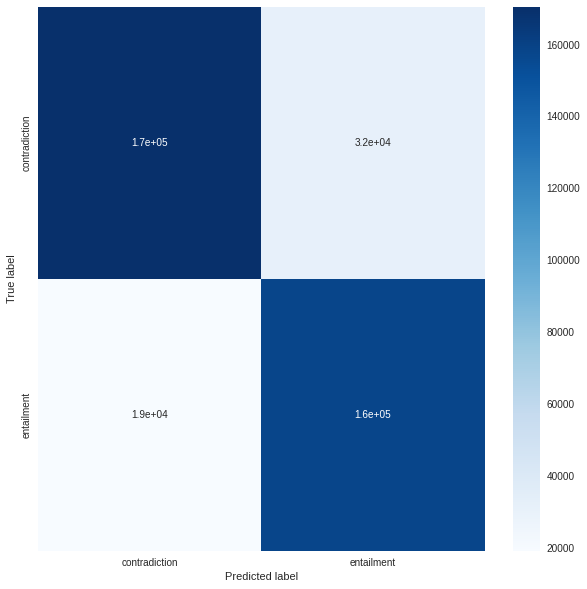

In [ ]:
#56
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Live Test

The proposed system can benefit from the ability to analyze and link tweets that are similar in meaning with each other, and thus show the way in which Twitter can review similar tweets as suggestions to users, depending on the match in terms of meaning.
Examples of datasets that can be used:
https://www.kaggle.com/datasets/vishesh1412/twitter-dataset-sri-lanka-crisis/

In [ ]:
sen1 = "In Sri Lanka, the demonstrators went out in many demonstrations against the government, the demonstrators managed to reach the presidential residence of the president, and news of the president's escape."
sen2 = "In Sri Lanka, the atmosphere is wonderful, and the tourist areas are spread in large quantity, the prices are rather low, and it has a comfortable political and economic stability, I recommend visiting it, it has many wonderful monuments."

In [ ]:
def pre_processing_sentence(sentence):
  texts = []
  pred_input = sentence
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  pred_input = [word for word in pred_input.split() if word not in stop_words]
  pred_input = ' '.join(pred_input)
  print(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],43)
  return pred_input

**Note:**
Tokenizer depends on the words contained in the trained data (word dictionary), and therefore for new words that the Tokenizer has not been trained on, the Tokenizer will remove them.

In [ ]:
sen1 = pre_processing_sentence(sen1)

sri lanka demonstrators went many demonstrations government demonstrators managed reach presidential residence president news presidents escape


In [ ]:
sen1

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1595,  171, 4060, 1638, 4001, 2291, 3309]],
      dtype=int32)

In [ ]:
sen2 = pre_processing_sentence(sen2)

sri lanka atmosphere wonderful tourist areas spread large quantity prices rather low comfortable political economic stability recommend visiting many wonderful monuments


In [ ]:
sen2

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1486, 1669,   37, 5030, 3390, 1107, 5035, 3018, 2055,  171]],
      dtype=int32)

In [ ]:
full_input = np.asarray([sen1, sen2])

In [ ]:
full_input.shape

(2, 1, 43)

In [ ]:
full_input = full_input.reshape(1, 2, 43)

In [ ]:
full_input.shape

(1, 2, 43)

In [ ]:
y_predict = m.predict(full_input)

1/1 [==============================] - 0s 24ms/step


In [ ]:
y_predict

array([[1.0000000e+00, 1.9133919e-20]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_predict)

In [ ]:
classes_name = ['contradiction', 'entailment']

In [ ]:
y_predict[0][y_pred]*100

100.0

In [ ]:
classes_name[y_pred]

'contradiction'